<font size = 6> AUTOMATIC LICENSE PLATE RECOGNITION USING CONVOLUTIONAL NEURAL NETWORK

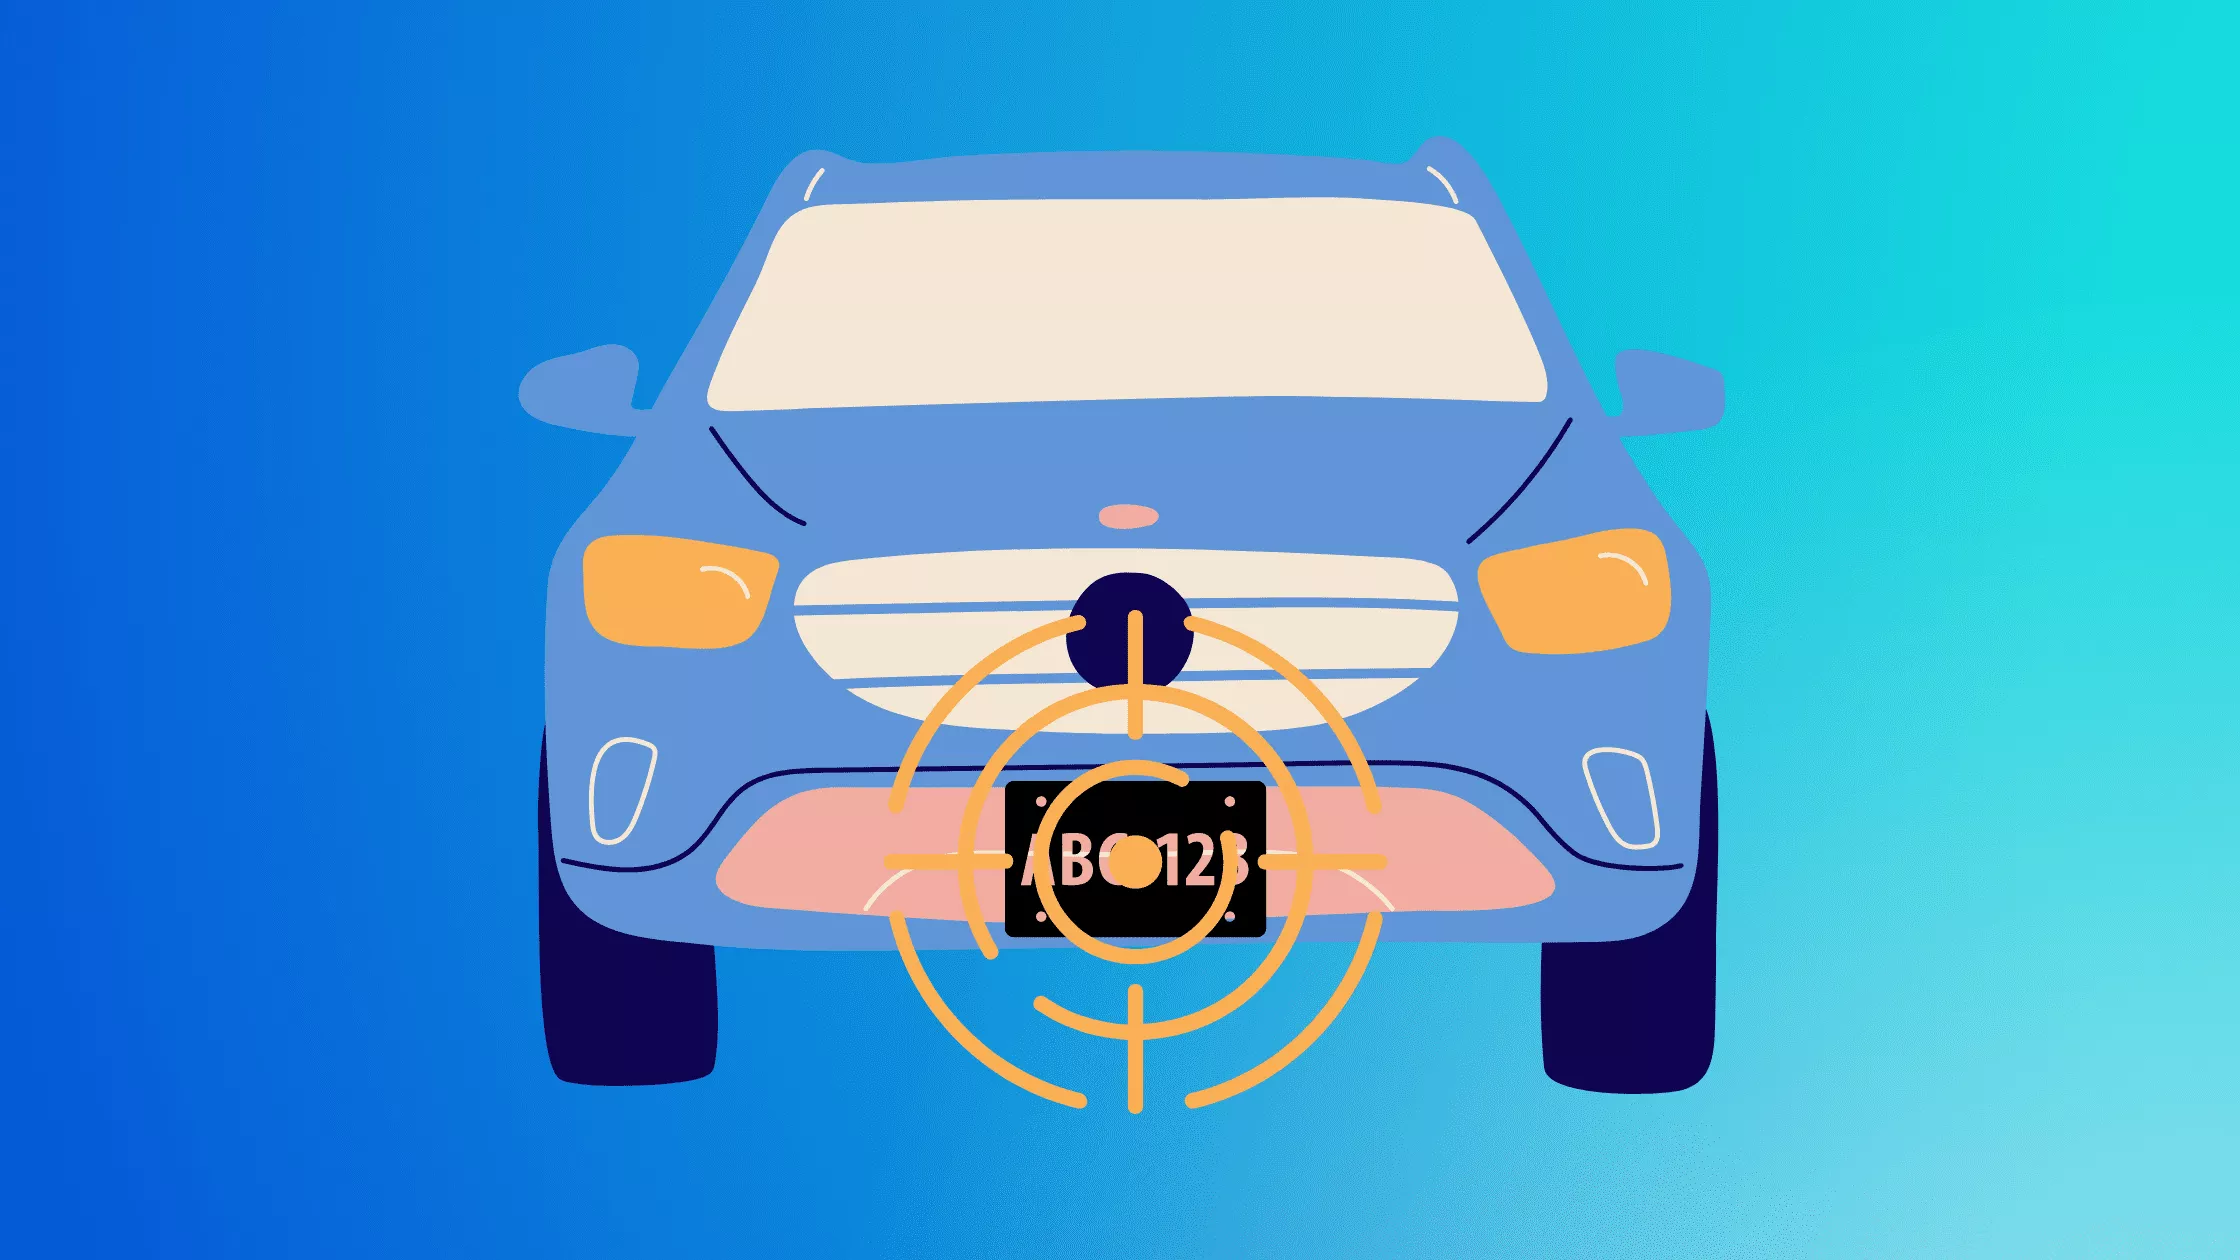

1. MOUNTING DRIVE

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


2. LOADING LIBRARIES

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy


3. PARSING XML ANNOTATION FILES

In [ ]:
path = glob('../content/drive/MyDrive/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)


4. GETTING IMAGES FROM XML FILES

In [ ]:
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'../content/drive/MyDrive/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ../content/drive/MyDrive/images/N224.xml   164   272   223   247   
1  ../content/drive/MyDrive/images/N100.xml   134   301   312   350   
2  ../content/drive/MyDrive/images/N191.xml   317   568   319   397   
3   ../content/drive/MyDrive/images/N36.xml   392   517   161   213   
4  ../content/drive/MyDrive/images/N197.xml   120   184   103   130   

                                    filename  width  height  center_x  \
0  ../content/drive/MyDrive/images/N224.jpeg    442     333  0.493213   
1  ../content/drive/MyDrive/images/N100.jpeg    450     417  0.483333   
2  ../content/drive/MyDrive/images/N191.jpeg    650     572  0.680769   
3   ../content/drive/MyDrive/images/N36.jpeg    600     384  0.757500   
4  ../content/drive/MyDrive/images/N197.jpeg    350     197  0.434286   

   center_y  bb_width  bb_height  
0  0.705706  0.244344   0.072072  
1  0.793765  0.371111   0.091127  
2  0.625874  0.386154   0.136364  
3  0.486979  0.208333   0.135417  
4  0.591371  0.182857   0.137056

6. CHECKING AMOUNT OF IMAGES WE HAVE

In [ ]:
num_files_parsed = len(df)
print(f"Number of XML files parsed: {num_files_parsed}")

Number of XML files parsed: 1484


7. Calculate the center_x, center_y, width and height, which is normalized to width and height. And as well normalize width and height of bounding box.

In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ../content/drive/MyDrive/images/N224.xml   164   272   223   247   
1  ../content/drive/MyDrive/images/N100.xml   134   301   312   350   
2  ../content/drive/MyDrive/images/N191.xml   317   568   319   397   
3   ../content/drive/MyDrive/images/N36.xml   392   517   161   213   
4  ../content/drive/MyDrive/images/N197.xml   120   184   103   130   

                                    filename  width  height  center_x  \
0  ../content/drive/MyDrive/images/N224.jpeg    442     333  0.493213   
1  ../content/drive/MyDrive/images/N100.jpeg    450     417  0.483333   
2  ../content/drive/MyDrive/images/N191.jpeg    650     572  0.680769   
3   ../content/drive/MyDrive/images/N36.jpeg    600     384  0.757500   
4  ../content/drive/MyDrive/images/N197.jpeg    350     197  0.434286   

   center_y  bb_width  bb_height  
0  0.705706  0.244344   0.072072  
1  0.793765  0.371111   0.091127  
2  0.625874  0.386154   0.136364  
3  0.486979  0.208333   0.135417  
4  0.591371  0.182857   0.137056

8. CREATING THE DIRECTORIES FOR OUR TRAIN AND TEST DATA

In [ ]:
!mkdir /content/yolo_data
!mkdir /content/yolo_data/yolo_train/
!mkdir /content/yolo_data/yolo_test/

mkdir: cannot create directory ‘/content/yolo_data’: File exists
mkdir: cannot create directory ‘/content/yolo_data/yolo_train/’: File exists
mkdir: cannot create directory ‘/content/yolo_data/yolo_test/’: File exists


9. I ALLOCATED 80 PERCENT OF THE DATASET FOR TRAINING 20 PERCENT FOR VALIDATION

In [ ]:
df_train = df.iloc[:1186]
df_test = df.iloc[297:]

10. POPULATING THE DIRECTORIES ACCORDINGLY

In [ ]:
from shutil import copy

def process_data(data, output_folder):
    for fname, x, y, w, h in data:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(output_folder, image_name)
        dst_label_file = os.path.join(output_folder, txt_name + '.txt')

        try:
            # copy each image into the folder
            copy(fname, dst_image_path)

            # generate .txt which has label info
            label_txt = f'0 {x} {y} {w} {h}'
            with open(dst_label_file, mode='w') as f:
                f.write(label_txt)
        except FileNotFoundError:
            print(f"Image '{fname}' not found. Skipping...")

train_folder = '/content/yolo_data/yolo_train'
test_folder = '/content/yolo_data/yolo_test'

# Process training data
train_values = df_train[['filename', 'center_x', 'center_y', 'bb_width', 'bb_height']].values
process_data(train_values, train_folder)

# Process testing data
test_values = df_test[['filename', 'center_x', 'center_y', 'bb_width', 'bb_height']].values
process_data(test_values, test_folder)


Image '../content/drive/MyDrive/images/NL1.jpg' not found. Skipping...


11. GETTING THE YOLO OBJECT DETECTION MODEL FROM GITHUB

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.72 MiB | 15.65 MiB/s, done.
Resolving deltas: 100% (11038/11038), done.


12. INSTALLING THE REQUIREMENTS FOR THE MODEL

In [ ]:
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.9/645.9 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


13. FREEING THE GPU MEMORY

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7395 sha256=ea02fe85ecef3efd5f8ea0c4c668c2afa0d2c47c9d0ef5ff8c5615bf2a49d27f
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  8% |  2% |


14. YOLOV5 MODEL TRAINING

In [ ]:
!python /content/yolov5/train.py --data /content/drive/MyDrive/train.yaml --cfg /content/yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

2023-11-28 12:50:16.936131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 12:50:16.936201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 12:50:16.936239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/train.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=Fal

15. CONVERTING TRAINED MODEL INTO THE ONNX FORMAT (OPEN NEURAL NETWORK EXCHANGE FORMAT)

In [ ]:
!python /content/yolov5/export.py --weight /content/yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['/content/yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.7 MB)

TorchScript: starting export with torch 2.1.0+cu118...
TorchScript: export success ✅ 2.3s, saved as /content/yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 

Lets display relevant graphs and images from our model

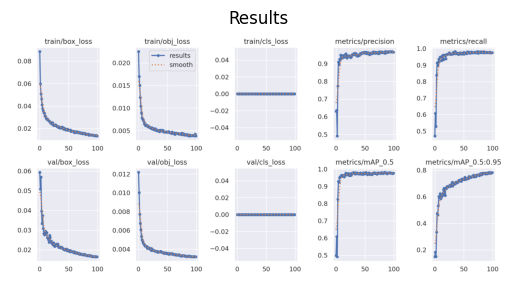

In [116]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/yolov5/runs/train/Model/results.png'  # Replace with the path to your specific image
image_title = 'Results'

img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title(image_title)
plt.show()


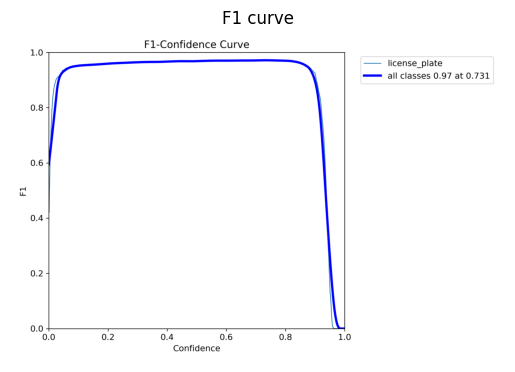

In [117]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/yolov5/runs/train/Model/F1_curve.png'  # Replace with the path to your specific image
image_title = 'F1 curve'

img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title(image_title)
plt.show()


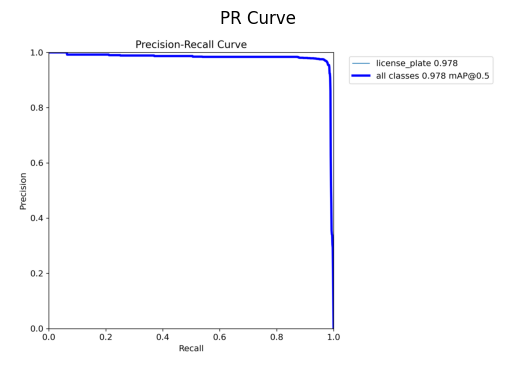

In [120]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/yolov5/runs/train/Model/PR_curve.png'  # Replace with the path to your specific image
image_title = 'PR Curve'

img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title(image_title)
plt.show()


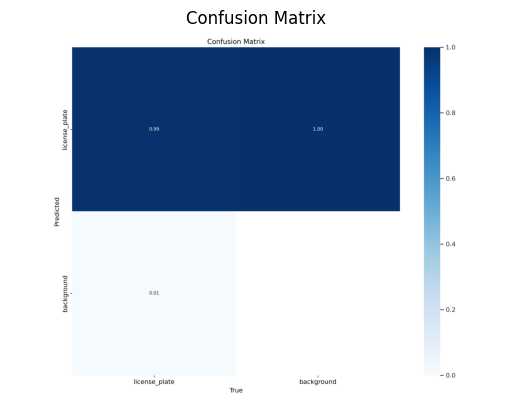

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/yolov5/runs/train/Model/confusion_matrix.png'  # Replace with the path to your specific image
image_title = 'Confusion Matrix'

img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title(image_title)
plt.show()


VALIDATON BATCH 0 LABELS

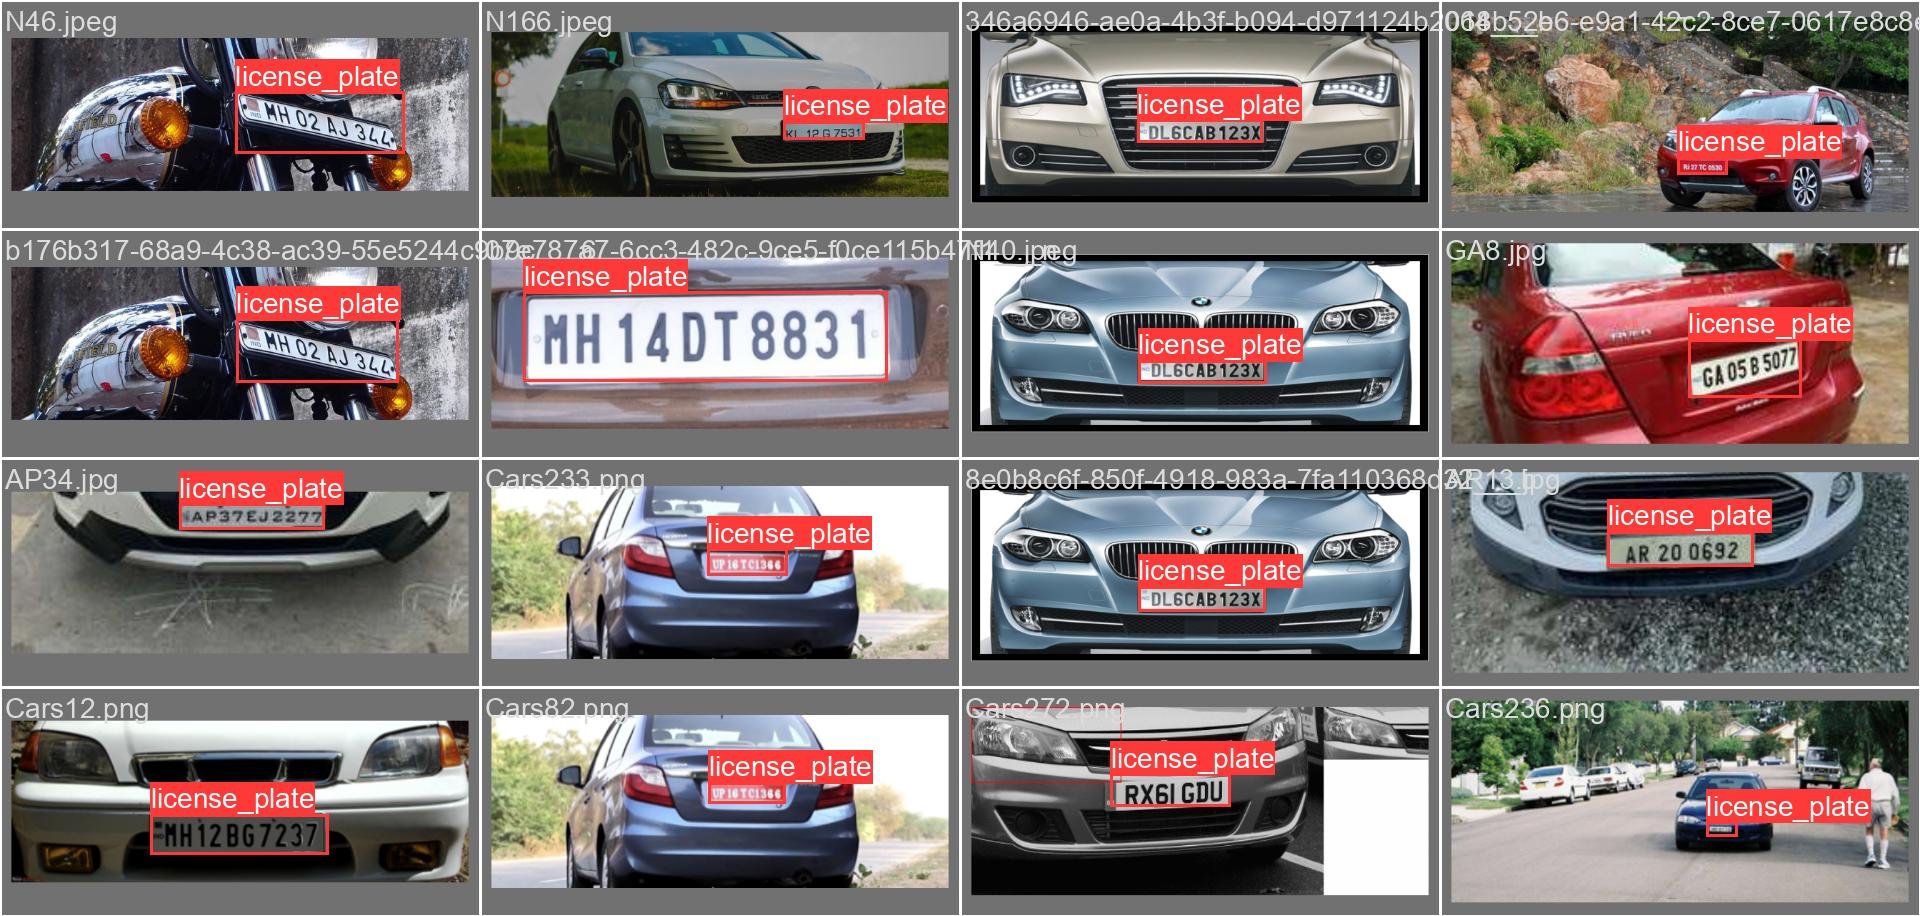

VALIDATION BATCH 0 PREDICTIONS

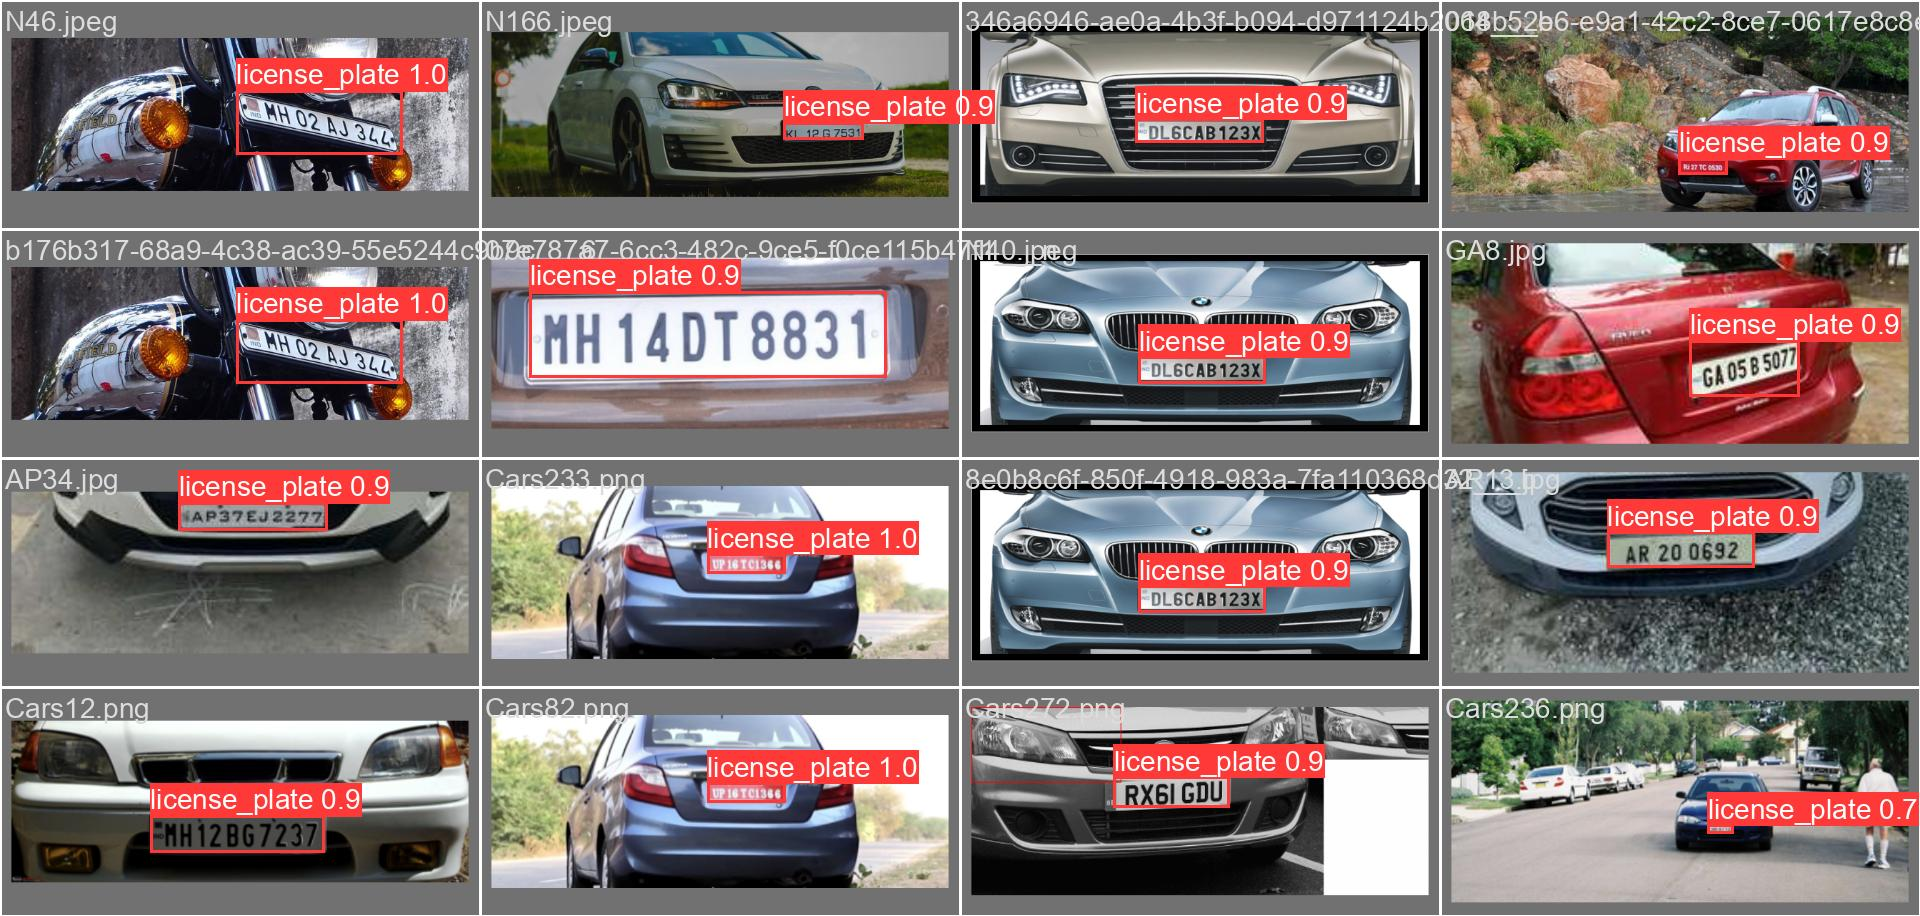

16. NOW WE CAN BEGIN INFERENCING THE MODEL

In [4]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

17. CHECKING THE IMAGE THAT WE WILL USE FOR PREDICTION

In [8]:
# LOAD THE IMAGE
img = io.imread('/content/drive/MyDrive/kenyanImages/kenyan15.png')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

18. LOADING OUR MODEL AND CARRYING OUT OBJECT DETECTION AND CHARACTER RECOGNITION

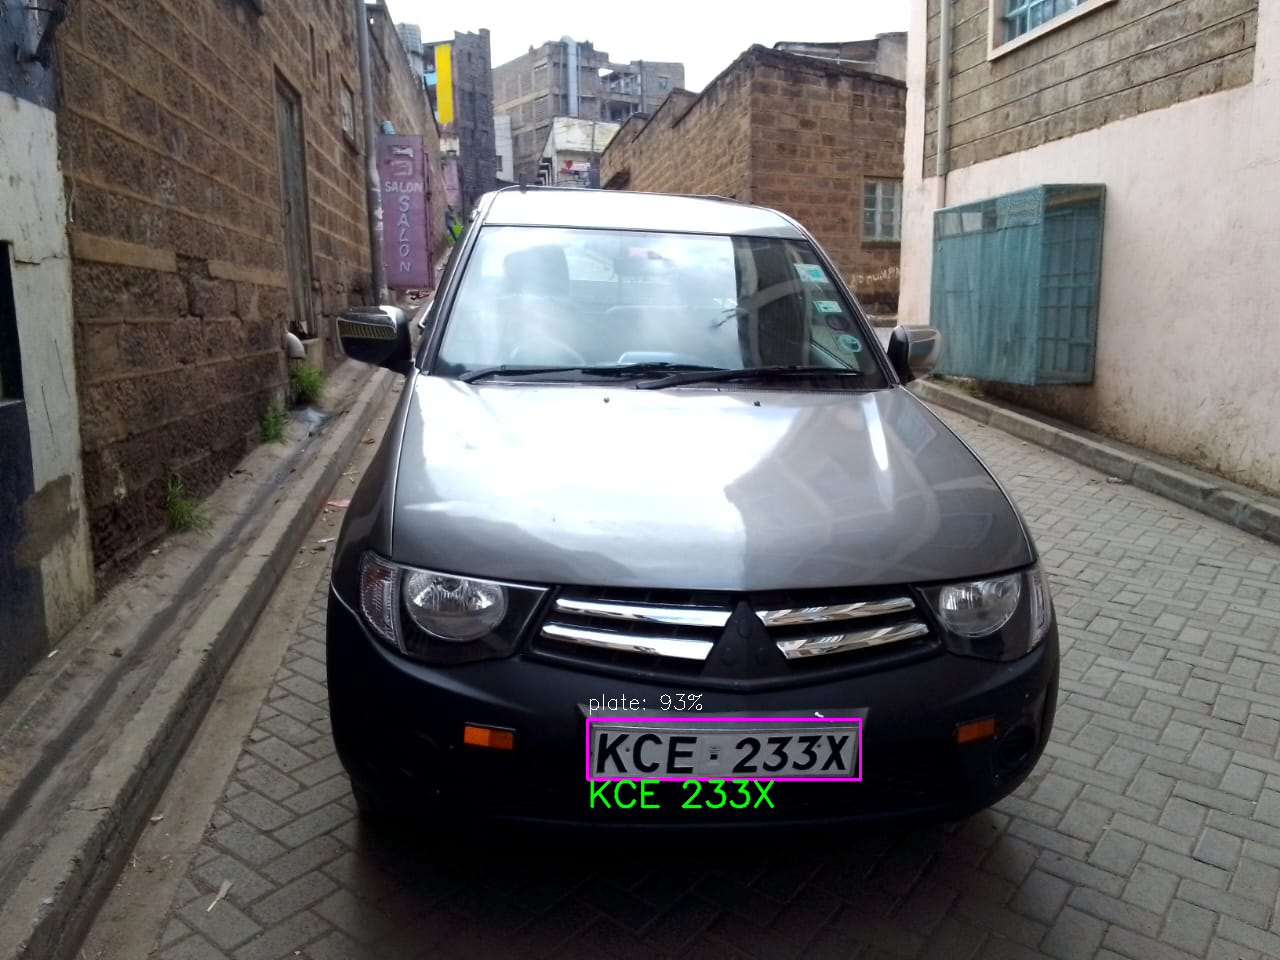

In [9]:
import cv2
import easyocr
from PIL import Image
from IPython.display import display

INPUT_WIDTH =  640
INPUT_HEIGHT = 640

# Load YOLO model
net = cv2.dnn.readNetFromONNX('/content/yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Function to perform YOLO object detection
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]

    return input_image, detections

def non_maximum_supression(input_image,detections):

    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE

    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)

    return boxes_np, confidences_np, index

# Function for performing OCR using EasyOCR on the detected ROIs
def perform_ocr_on_rois(image, boxes_np, confidences_np, index):
    reader = easyocr.Reader(['en'])  # Initialize EasyOCR with the expected language(s)

    for ind in index:
        x, y, w, h = boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)

        # Extract region of interest (ROI) for OCR
        roi = image[y:y+h, x:x+w]

        if 0 not in roi.shape:
            results = reader.readtext(roi)
            combined_text = ''  # Initialize combined text string

            # Concatenate all detected text within the ROI
            for detection in results:
                combined_text += detection[1] + ' '  # Concatenate text with space separator

            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 255), 2)
            cv2.putText(image, conf_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)

            # Modify the appearance of the OCR text
            text_font = cv2.FONT_HERSHEY_SIMPLEX
            text_scale = 1.2
            text_thickness = 2
            text_color = (0, 255, 0)  # Green color
            cv2.putText(image, combined_text.strip(), (x, y+h+27), text_font, text_scale, text_color, text_thickness, cv2.LINE_AA)

    return image

# Function to perform YOLO predictions and integrate OCR
def yolo_predictions(img, net):
    input_image, detections = get_detections(img, net)
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    result_img = perform_ocr_on_rois(img, boxes_np, confidences_np, index)
    return result_img

# Test your updated 'yolo_predictions' function
img = cv2.imread('/content/drive/MyDrive/kenyanImages/kenyan7.png')
results = yolo_predictions(img, net)

# Convert the OpenCV image to PIL format for display in Colab
results_pil = Image.fromarray(cv2.cvtColor(results, cv2.COLOR_BGR2RGB))
display(results_pil)


***UPLOADING TRAINED MODEL TO GOOGLE DRIVE FOR FUTURE USE***

In [11]:
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


source_folder_path = '/content/yolov5'


destination_folder_path = '/content/drive/MyDrive/YOLOV5model'


shutil.make_archive('/content/yolov5', 'zip', source_folder_path)


shutil.move('/content/yolov5.zip', destination_folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/YOLOV5model/yolov5.zip'